# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (ie 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - 
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Table of contents <a id='top'>

1. [EDA](#eda)
    1. [Portfolio](#portfolio)
    2. [Profile](#profile)
    3. [Transcript](#transcript)
2. [Preprocessing](#preprocessing)
    1. [Basic Preprocessing](#basic_preprocessing)
    2. [Creation of the "static" dataset](#static_dataset)
3. [The "Offer success" problem statement](#offer_success)
4. [Missing Data](#missing)
5. [Clustering](#clustering)
6. [Lagged features](#lagged)
7. [The "Profit in 10 days" problem statement](#profit)
8. [Results](#results)

In [78]:
import pandas as pd
import numpy as np
import math
import json
import os
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='solarizedd')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

import data_utils_mt.utils as utils
import seaborn as sns
from sklearn.pipeline import Pipeline
import datetime as dt
from xgboost import XGBClassifier

ROOT_DIR = '..'
DATA_DIR = os.path.join(ROOT_DIR, 'data')
DATA_RAW = os.path.join(DATA_DIR, 'raw')
DATA_INTERIM = os.path.join(DATA_DIR, 'interim')
DATA_EXTERNAL = os.path.join(DATA_DIR, 'external')
DATA_PROCESSED = os.path.join(DATA_DIR, 'processed')
SRC = os.path.join(ROOT_DIR, 'src')

import sys
sys.path.append(SRC)

import src.data.preprocessing as pp
import src.data.success_dataset as sd
import src.data.missing_data as md
import src.evaluation.offer_success as evos
from sklearn.cluster import KMeans

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
# read in the json files
portfolio = pd.read_json(os.path.join(DATA_RAW, 'portfolio.json'), orient='records', lines=True)
profile = pd.read_json(os.path.join(DATA_RAW, 'profile.json'), orient='records', lines=True)
transcript = pd.read_json(os.path.join(DATA_RAW, 'transcript.json'), orient='records', lines=True)

# 1. EDA <a id='eda'></a>
[Top](#top)

## 1.A. Portfolio <a id='portfolio'></a>
[Top](#top)

In [80]:
print(portfolio.shape)
portfolio.sort_values(by='offer_type')

(10, 6)


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0


Let's substitute the "channels" column with one hot encoded columns.

In [81]:
portfolio = pp.channels_ohe(portfolio)
portfolio

,difficulty,duration,id,offer_type,reward,channel_web,channel_mobile,channel_email,channel_social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,1,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,1,1,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,1,0


## 1.B. Profile <a id='profile'></a>
[Top](#top)

In [82]:
print(profile.shape)
profile.head()

(17000, 5)


,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [83]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [84]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

The age = 118 looks strange

In [85]:
profile.age.value_counts()[:10]

118    2175
58      408
53      372
51      363
54      359
59      359
57      353
52      351
55      350
56      342
Name: age, dtype: int64

It's almost certain that 118 was the value used for NaNs in the age. It also seems likely that the customers that have any missing data, have all the 'profile' data missing. Let's test that.

In [86]:
profile.age = profile.age.replace(118, np.nan)
profile.isnull().sum(axis=1).unique()

array([3, 0])

That means that customers have 3 missing values or none, as supposed earlier.

Let's separate the customers in those who have missing data and those who don't. If a customer has all its profile missing, and doesn't have any entry in the transcript dataframe, then it should be ignored (as we don't have any information of use about the client). Are there any of those?

In [87]:
profile['missing_demographics'] = profile.isnull().any(axis=1).astype(int)
profile.head()

,age,became_member_on,gender,id,income,missing_demographics
0,NaN,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,1
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,0
2,NaN,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,1
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0
4,NaN,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN,1


In [88]:
utils.common_values(profile.id, transcript.person)

Intersection: 17000
Total set 1: 17000
Not in set 2: 0
Total set 2: 17000
Not in set 1: 0
Total: 17000


All the customers in the "profile" dataframe are in the "transcript" dataframe also. That means all customers give at least some information, and cannot be dropped.

### Let's transform the dates

In [89]:
profile.became_member_on = pd.to_datetime(profile.became_member_on, 
                                          format='%Y%m%d')
profile.head()

,age,became_member_on,gender,id,income,missing_demographics
0,NaN,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,1
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,0
2,NaN,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,1
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0
4,NaN,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN,1


### And encode the gender

In [90]:
gender_dict = {'F': 0, 'M': 1, 'O': 2, None: np.nan}
gender_dict_inverse = {0: 'F', 1: 'M', 2: 'O', np.nan: None}
profile.gender = profile.gender.replace(gender_dict)
profile.head()

,age,became_member_on,gender,id,income,missing_demographics
0,NaN,2017-02-12,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,1
1,55.0,2017-07-15,0.0,0610b486422d4921ae7d2bf64640c50b,112000.0,0
2,NaN,2018-07-12,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,1
3,75.0,2017-05-09,0.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0
4,NaN,2017-08-04,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,1


### Let's find a good format to use the dates in the estimators

In [91]:
# Create a feature that shows when a customer became member, 
# as the number of days since January 1st, 1970, to the signup date.
profile['member_since_epoch'] = (
    profile.became_member_on - dt.datetime(1970,1,1)).dt.days
profile.head()

,age,became_member_on,gender,id,income,missing_demographics,member_since_epoch
0,NaN,2017-02-12,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,1,17209
1,55.0,2017-07-15,0.0,0610b486422d4921ae7d2bf64640c50b,112000.0,0,17362
2,NaN,2018-07-12,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,1,17724
3,75.0,2017-05-09,0.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,17295
4,NaN,2017-08-04,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,1,17382


### How do the features look like?

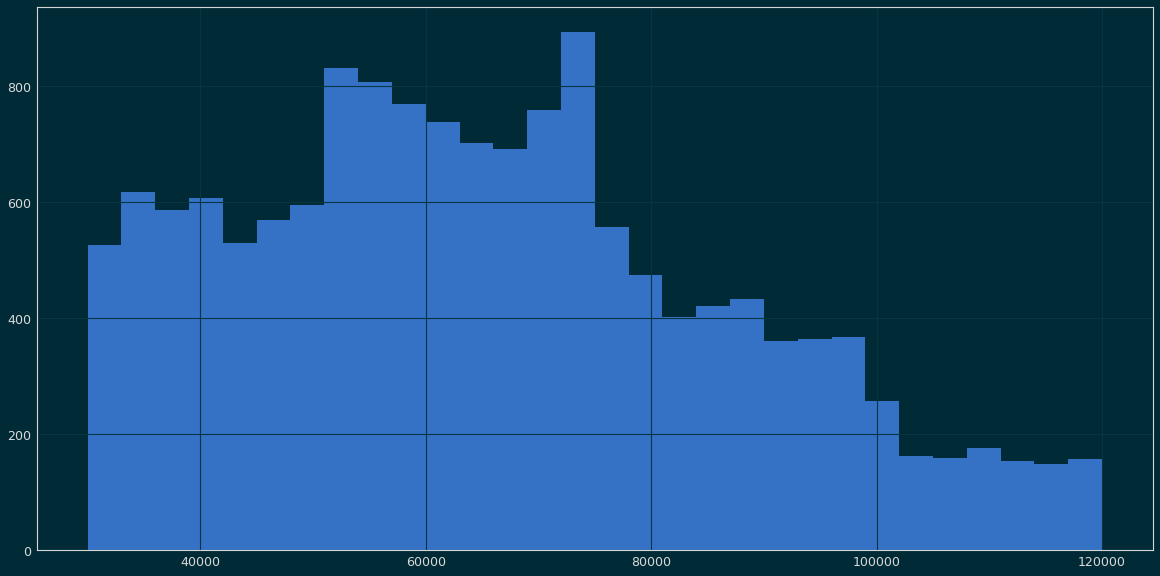

In [92]:
profile.income.hist(bins=30)

In [93]:
profile.gender.value_counts(dropna=False)

 1.0    8484
 0.0    6129
NaN     2175
 2.0     212
Name: gender, dtype: int64

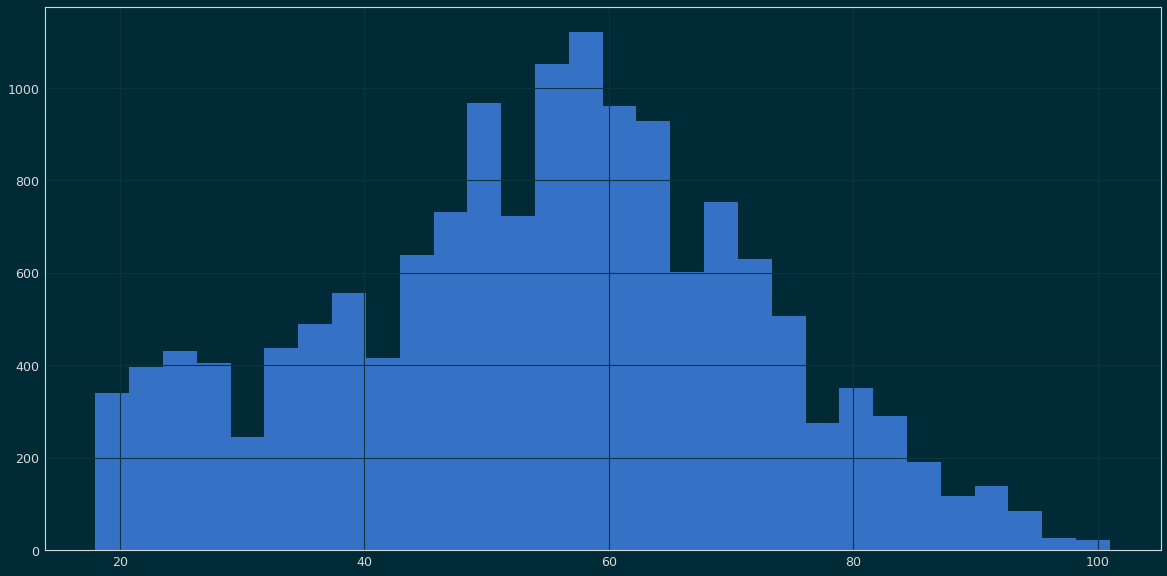

In [94]:
profile.age.hist(bins=30)

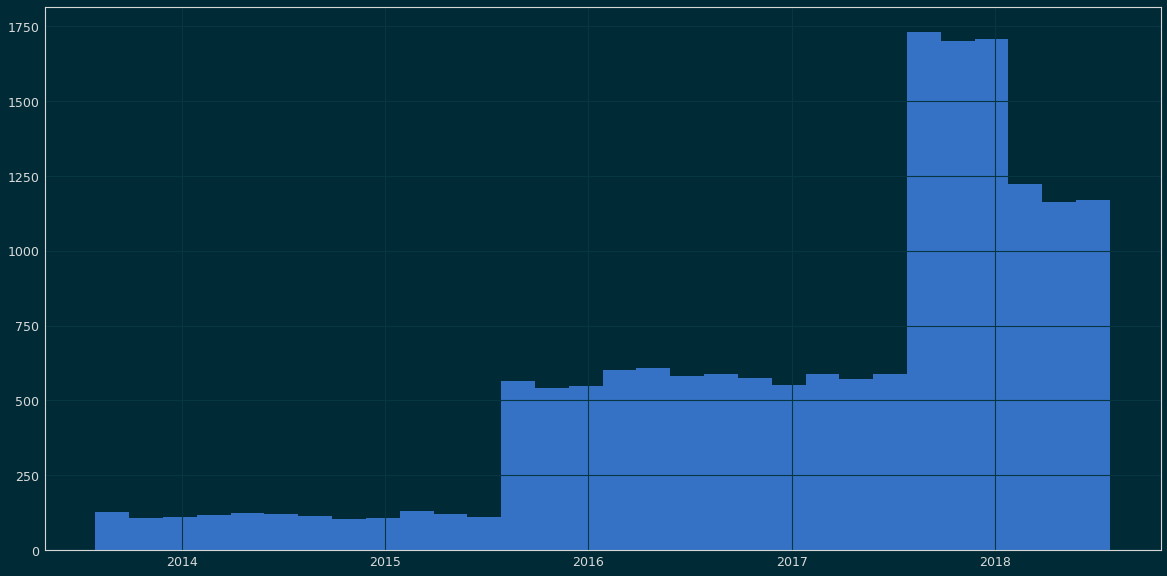

In [95]:
profile.became_member_on.hist(bins=30)

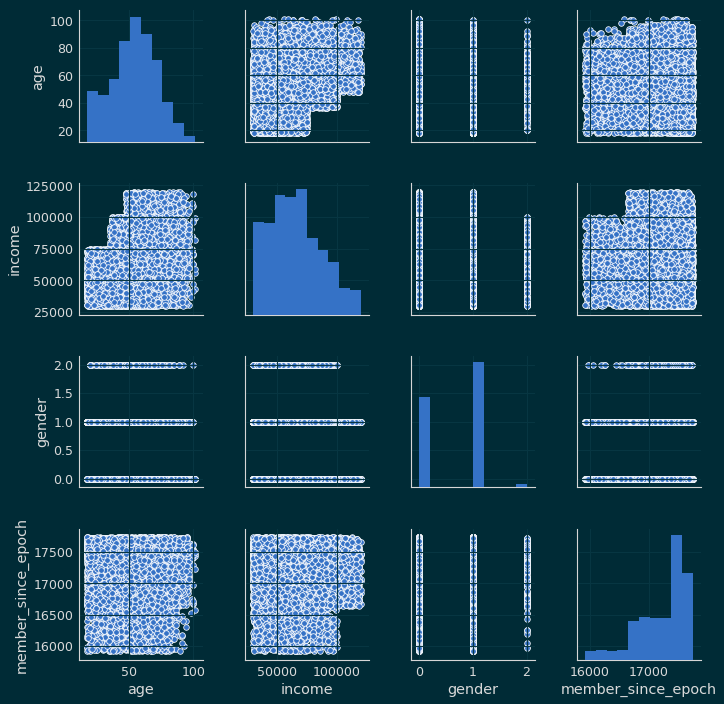

In [96]:
sns.pairplot(profile[['age', 
                      'income', 
                      'gender', 
                      'member_since_epoch']].dropna())

There is a very strange age-income "stair" pattern... I assume that is due to the inner workings of the simulator.

**Finding:** The simulator seems to cap the income for younger customers, in discrete steps.

## 1.C. Transcript <a id='transcript'></a>
[Top](#top)

In [97]:
print(transcript.shape)
transcript.head()

(306534, 4)


,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [98]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [99]:
transcript.time.unique()

array([  0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,
        78,  84,  90,  96, 102, 108, 114, 120, 126, 132, 138, 144, 150,
       156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228,
       234, 240, 246, 252, 258, 264, 270, 276, 282, 288, 294, 300, 306,
       312, 318, 324, 330, 336, 342, 348, 354, 360, 366, 372, 378, 384,
       390, 396, 402, 408, 414, 420, 426, 432, 438, 444, 450, 456, 462,
       468, 474, 480, 486, 492, 498, 504, 510, 516, 522, 528, 534, 540,
       546, 552, 558, 564, 570, 576, 582, 588, 594, 600, 606, 612, 618,
       624, 630, 636, 642, 648, 654, 660, 666, 672, 678, 684, 690, 696,
       702, 708, 714])

In [100]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

Let's get the "value" data out of the dictionaries, and then check each type of event separately.

In [101]:
transcript = pp.unwrap_transcript(transcript)

In [102]:
transcript[transcript.event == 'offer received'].head()

,event,person,time,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [103]:
transcript[transcript.event == 'offer viewed'].head()

,event,person,time,amount,offer_id,reward
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,NaN,ae264e3637204a6fb9bb56bc8210ddfd,NaN
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN


In [104]:
transcript[transcript.event == 'transaction'].head()

,event,person,time,amount,offer_id,reward
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83,NaN,NaN
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,NaN,NaN
12659,transaction,54890f68699049c2a04d415abc25e717,0,13.23,NaN,NaN
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,NaN,NaN
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,NaN,NaN


In [105]:
transcript[transcript.event == 'offer completed'].head()

,event,person,time,amount,offer_id,reward
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,NaN,2906b810c7d4411798c6938adc9daaa5,2.0
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,NaN,ae264e3637204a6fb9bb56bc8210ddfd,10.0
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0


The "event" column could be Label-encoded but, other than that, there don't seem to be many simple preprocessing actions to take. There is still a lot of data wrangling before having a well posed problem, though.

Let's make a dataset that doesn't take into account the particular person or offer, but rather their features.

In [106]:
static_df = pp.join_data(transcript, profile, portfolio)
static_df.head()

,event,time,amount,reward,age,became_member_on,gender,income,missing_demographics,member_since_epoch,difficulty,duration,offer_type,reward_t,channel_web,channel_mobile,channel_email,channel_social
0,offer received,0,NaN,NaN,75.0,2017-05-09,0.0,100000.0,0,17295,5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0
1,offer received,0,NaN,NaN,NaN,2017-08-04,NaN,NaN,1,17382,20.0,10.0,discount,5.0,1.0,0.0,1.0,0.0
2,offer received,0,NaN,NaN,68.0,2018-04-26,1.0,70000.0,0,17647,10.0,7.0,discount,2.0,1.0,1.0,1.0,0.0
3,offer received,0,NaN,NaN,NaN,2017-09-25,NaN,NaN,1,17434,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0
4,offer received,0,NaN,NaN,NaN,2017-10-02,NaN,NaN,1,17441,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0


In [107]:
static_df.duration.unique()

array([ 7., 10.,  5.,  4.,  3., nan])

### Let's check how often offers are sent to customers, and if the timings are coordinated.

In [108]:
merged_df = pp.join_data(transcript, profile, portfolio, static=False)
merged_df.head()

,event,person,time,amount,offer_id,reward,age,became_member_on,gender,income,missing_demographics,member_since_epoch,difficulty,duration,offer_type,reward_t,channel_web,channel_mobile,channel_email,channel_social
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.0,2017-05-09,0.0,100000.0,0,17295,5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,2017-08-04,NaN,NaN,1,17382,20.0,10.0,discount,5.0,1.0,0.0,1.0,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,68.0,2018-04-26,1.0,70000.0,0,17647,10.0,7.0,discount,2.0,1.0,1.0,1.0,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,2017-09-25,NaN,NaN,1,17434,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,2017-10-02,NaN,NaN,1,17441,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0


In [109]:
def get_differences(user_events):
    return pd.DataFrame((user_events.time - user_events.time.shift(1)).values)

In [110]:
# "delays" shows the time differences between consecutive offers for each
# user.
sent = merged_df[merged_df.event == 'offer received']
delays = sent.groupby('person').apply(get_differences).rename(
    columns={0: 'diff'})
delays = delays.unstack()
delays.head()

diff                              
                                    0      1      2     3     4   5
person                                                             
0009655768c64bdeb2e877511632db8f  NaN  168.0   72.0  96.0  72.0 NaN
00116118485d4dfda04fdbaba9a87b5c  NaN  408.0    NaN   NaN   NaN NaN
0011e0d4e6b944f998e987f904e8c1e5  NaN  168.0  168.0  72.0  96.0 NaN
0020c2b971eb4e9188eac86d93036a77  NaN  168.0  168.0  72.0  96.0 NaN
0020ccbbb6d84e358d3414a3ff76cffd  NaN  168.0   72.0  96.0   NaN NaN

Text(0.5, 1.0, 'Time difference between two consecutive offers, for each user')

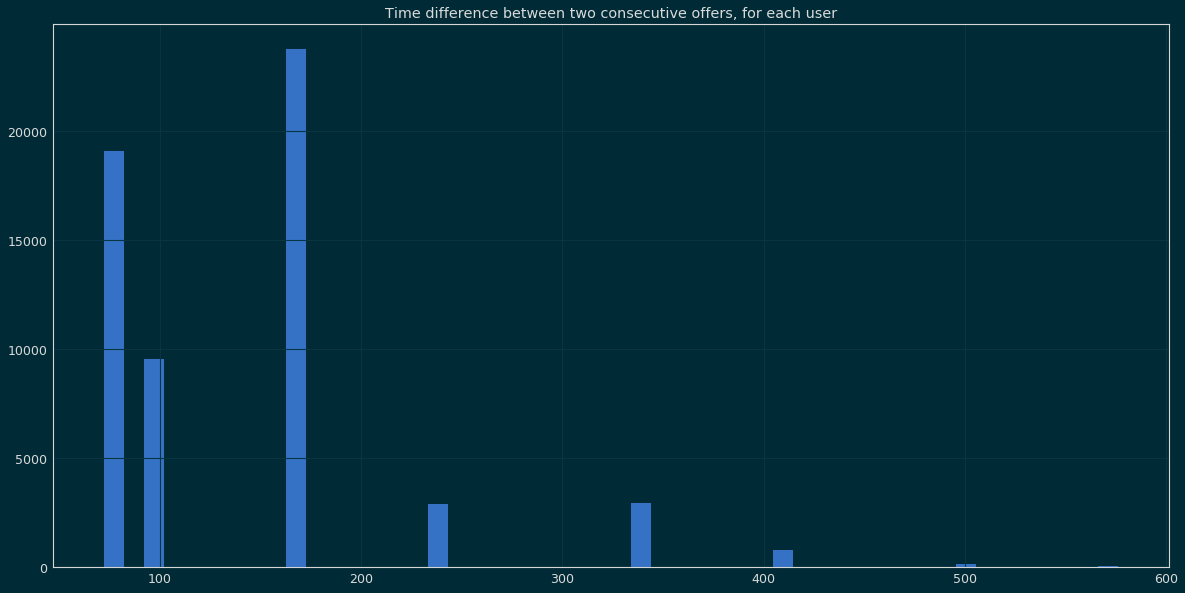

In [111]:
diffs = delays.values.flatten()
diffs = diffs[~np.isnan(diffs)]
diffs = pd.Series(diffs)
diffs.hist(bins=50)
plt.title('Time difference between two consecutive offers, for each user')

In [112]:
diffs.value_counts()

168.0    23754
72.0     19109
96.0      9557
336.0     2942
240.0     2908
408.0      810
504.0      156
576.0       47
dtype: int64

In [113]:
d_vals = diffs.sort_values().unique()
d_vals

array([ 72.,  96., 168., 240., 336., 408., 504., 576.])

In [114]:
d_vals[1:] - d_vals[:-1]

array([24., 72., 72., 96., 72., 96., 72.])

### The offers are being clearly sent in a coordinated fashion, and sent in very specific times. The times are multiples of 24. Let's investigate further.

In [115]:
# Times contains the time at which each offer was sent
times = sent.groupby('person').apply(lambda x: pd.DataFrame(x.time.values)).rename(
    columns={0: 'times'}).unstack()
times.head()

times                                
                                      0      1      2      3      4   5
person                                                                 
0009655768c64bdeb2e877511632db8f  168.0  336.0  408.0  504.0  576.0 NaN
00116118485d4dfda04fdbaba9a87b5c  168.0  576.0    NaN    NaN    NaN NaN
0011e0d4e6b944f998e987f904e8c1e5    0.0  168.0  336.0  408.0  504.0 NaN
0020c2b971eb4e9188eac86d93036a77    0.0  168.0  336.0  408.0  504.0 NaN
0020ccbbb6d84e358d3414a3ff76cffd  168.0  336.0  408.0  504.0    NaN NaN

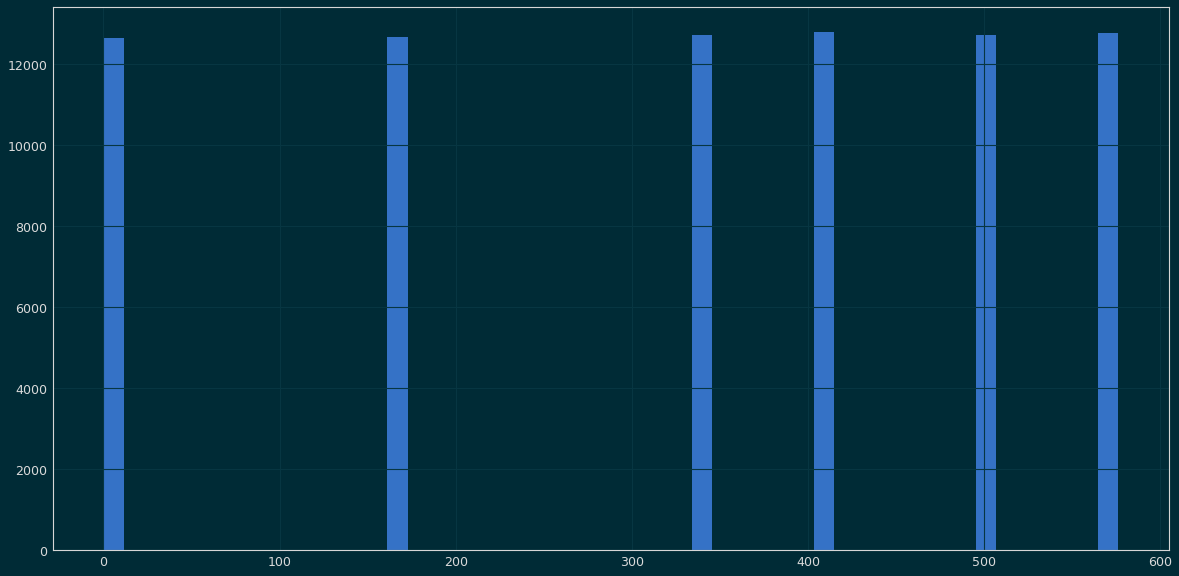

In [116]:
send_times = times.values.flatten()
send_times = pd.Series(send_times[~np.isnan(send_times)])
send_times.hist(bins=50)

In [117]:
send_times.value_counts()

408.0    12778
576.0    12765
336.0    12711
504.0    12704
168.0    12669
0.0      12650
dtype: int64

Let's check if they are all multiples of 24.

In [118]:
time_values = send_times.sort_values().unique()
time_values / 24

array([ 0.,  7., 14., 17., 21., 24.])

Indeed, all the sending times are multiples of 24 (one day).

### Let's look at the transactions in time, and the effect of the offers.

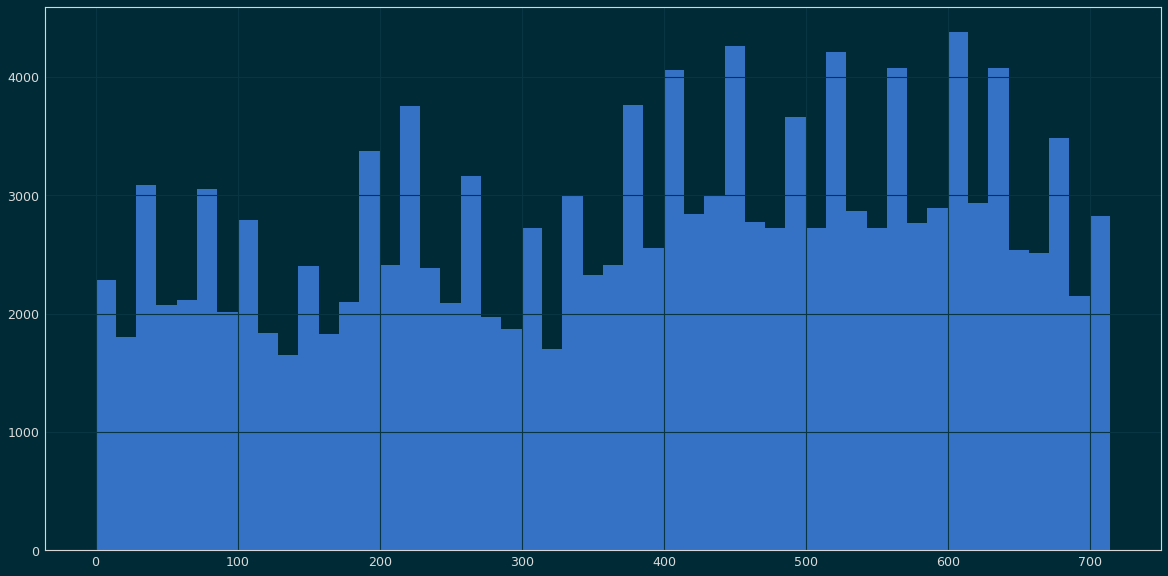

In [119]:
transactions = merged_df[merged_df.event == 'transaction']
transactions.time.hist(bins=50)

In [120]:
transaction_t_values = transactions.groupby('time').time.count()
transaction_t_values.head()

time
0     633
6     797
12    850
18    879
24    922
Name: time, dtype: int64

Transaction times go in steps of size 6, which is the minimum "tick" of simulator (or at least of the dataset provided). That means that transactions occur at any time of the day.

Let's look at the effects of the offers in transactions.

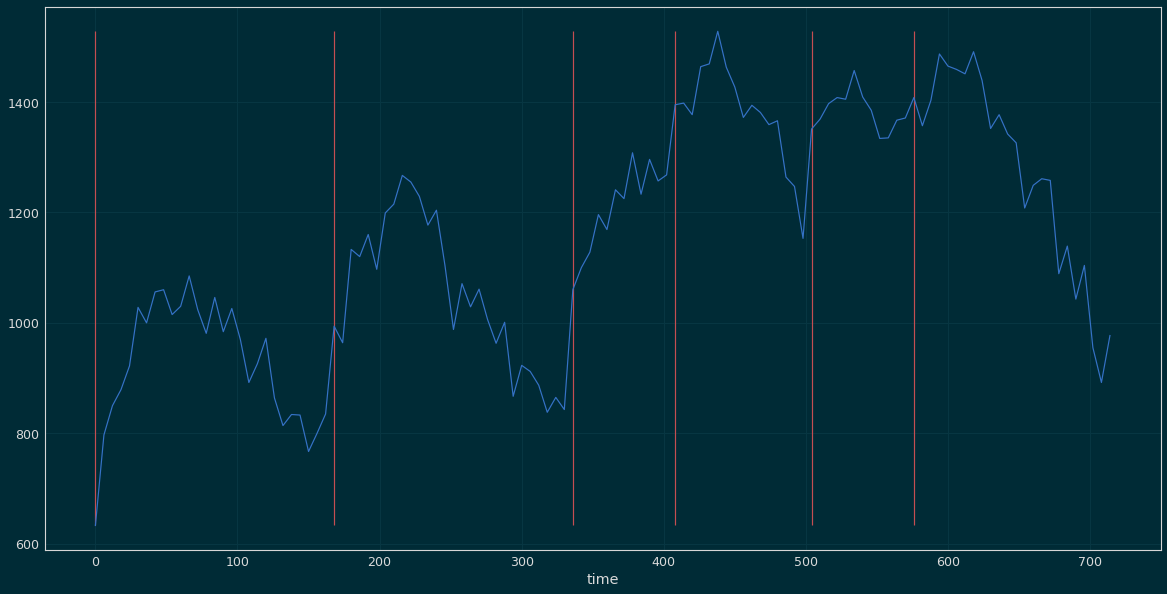

In [121]:
transaction_t_values.plot()
for time_value in time_values:
    plt.vlines(time_value, 
               transaction_t_values.min(),
               transaction_t_values.max(), 'r', label='offers sending')
plt.title('Amount of transactions and offers sending times')

The advertising seems to be having a positive effect, overall. Also, that effect seems to last more than 168 hours after the start of the offer, which is about 7 days. Some offers have a duration of 10 days.

That means that there could be overlapping between the effects of one offer and the next. That should be checked.

Initially, at least, the effect of an offer will be assessed in one particular client, although it is clear that some offers also affect the behavior of other clients. In particular BOGO offers seem to be very suitable to acquire new clients, when an existing customer invites a coffe ("for free") to another person, for example. Perhaps, in future notebooks that effect will be considered, but not initially.

### Is there any overlapping between the effects of offers?

Let's study one case (if there is overlapping in that case, we will know that the simulator makes offers that may overlap. If not, we may look at other customers or find a general procedure to find overlapping in the full dataset.).

In [122]:
person = merged_df[merged_df.person == merged_df.person[0]]
offers = person[person.event.isin(['offer received', 'offer completed'])]
offers = offers[['event', 'time', 'duration', 'offer_id']]
reception = offers[offers.event == 'offer received'].copy()
reception['expected_finish'] = reception.time + 24 * reception.duration
reception

,event,time,duration,offer_id,expected_finish
0,offer received,0,7.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,168.0
53176,offer received,168,3.0,5a8bc65990b245e5a138643cd4eb9837,240.0
150598,offer received,408,7.0,ae264e3637204a6fb9bb56bc8210ddfd,576.0
201572,offer received,504,5.0,f19421c1d4aa40978ebb69ca19b0e20d,624.0


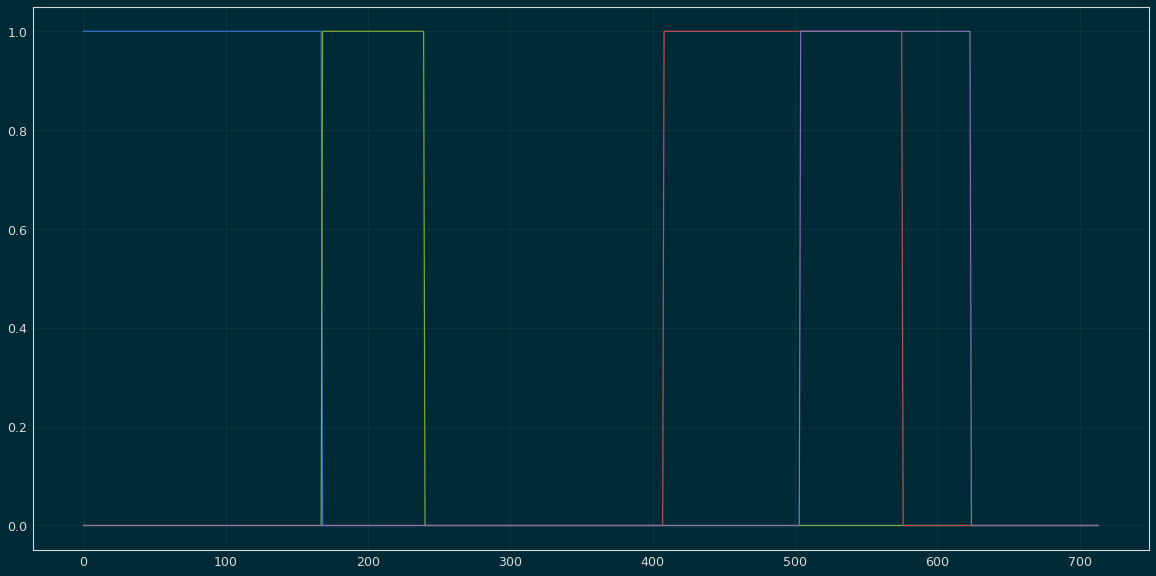

In [123]:
# This plots the times while each offer is "active".
for idx, row in reception.iterrows():
    x = np.arange(merged_df.time.max()).astype(int)  # Total time
    x_on = np.arange(row.time, row.expected_finish).astype(int)  # Time when the offer is "active"
    y = np.zeros(merged_df.time.max())
    y[x_on] = 1
    plt.plot(x, y)

spending = np.zeros(merged_df.time.max())
spending[person.time] = person.amount
plt.plot(x, spending / spending.sum())

There is clear overlapping in that case. That suggests that overlapping of offer effects is not a rare phenomenon, and will obviously introduce some distortions.

# 2. Preprocessing <a id='preprocessing'></a>
[Top](#top)

Based on what was seen in the EDA, some functions were implemented to preprocess the raw data. The initial functions preprocess the data individually, and then other functions create a "static" dataset. It is "static" in the sense that it is created to be useful under the assumption that the customers' behavior is stationary, and that an estimator can ignore the "absolute" time feature.

The preprocessing process will be shown below, using the implemented functions. After that, the full process can be run by calling just two functions:
 - basic_preprocessing
 - generate_static_dataset

In [124]:
%reset -f

In [125]:
import pandas as pd
import numpy as np
import math
import json
import os
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='solarizedd')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

import data_utils_mt.utils as utils
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import datetime as dt

ROOT_DIR = '..'
DATA_DIR = os.path.join(ROOT_DIR, 'data')
DATA_RAW = os.path.join(DATA_DIR, 'raw')
DATA_INTERIM = os.path.join(DATA_DIR, 'interim')
DATA_EXTERNAL = os.path.join(DATA_DIR, 'external')
DATA_PROCESSED = os.path.join(DATA_DIR, 'processed')
SRC = os.path.join(ROOT_DIR, 'src')

import sys
sys.path.append(SRC)

import src.data.preprocessing as pp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
# read in the json files
portfolio = pd.read_json(os.path.join(DATA_RAW, 'portfolio.json'), orient='records', lines=True)
profile = pd.read_json(os.path.join(DATA_RAW, 'profile.json'), orient='records', lines=True)
transcript = pd.read_json(os.path.join(DATA_RAW, 'transcript.json'), orient='records', lines=True)

## 2.1 Basic Preprocessing <a id='basic_preprocessing'></a>
[Top](#top)

### Portfolio: One hot encode the offers' channels

In [127]:
portfolio = pp.process_portfolio(portfolio)
portfolio

,difficulty,duration,id,offer_type,reward,channel_web,channel_mobile,channel_email,channel_social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,1,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,1,1,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,1,0


### Profile: Substitute 118 with NaN, format dates, create date feature, add "missing demographics" feature

In [128]:
profile = pp.process_profile(profile)
print(profile.shape)
profile.head()

(17000, 7)


,age,became_member_on,gender,id,income,missing_demographics,member_epoch_days
0,NaN,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,1,17209
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,0,17362
2,NaN,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,1,17724
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,17295
4,NaN,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN,1,17382


### Transcript: Unwrap the "value" dictionaries

In [129]:
transcript = pp.process_transcript(transcript)
print(transcript.shape)
transcript.head()

(306534, 6)


,event,person,time,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


### Do it all at once and join the dataframes.

In [130]:
portfolio = pd.read_json(os.path.join(DATA_RAW, 'portfolio.json'), orient='records', lines=True)
profile = pd.read_json(os.path.join(DATA_RAW, 'profile.json'), orient='records', lines=True)
transcript = pd.read_json(os.path.join(DATA_RAW, 'transcript.json'), orient='records', lines=True)

data, portfolio = pp.basic_preprocessing(portfolio, profile, transcript)

print(data.shape)
data.head()

(306534, 20)


,event,person,time,amount,offer_id,reward,age,became_member_on,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_web,channel_mobile,channel_email,channel_social
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.0,2017-05-09,F,100000.0,0,17295,5.0,7.0,bogo,5.0,1.0,1.0,1.0,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,2017-08-04,None,NaN,1,17382,20.0,10.0,discount,5.0,1.0,0.0,1.0,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,68.0,2018-04-26,M,70000.0,0,17647,10.0,7.0,discount,2.0,1.0,1.0,1.0,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,2017-09-25,None,NaN,1,17434,10.0,10.0,discount,2.0,1.0,1.0,1.0,1.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,2017-10-02,None,NaN,1,17441,10.0,5.0,bogo,10.0,1.0,1.0,1.0,1.0


## 2.2 Creation of the "static" dataset <a id='static_dataset'></a>
[Top](#top)

The process will be shown for a single customer, and then the full dataset is calculated.

In [131]:
person = data[data.person == data.person.iloc[0]]

### Split the dataset for convenience, according to the event type.

In [132]:
received, viewed, completed, transactions = pp.split_transcript(person)

### Add the "completed" column

The next thing to do is to add a column that tell whether an offer was completed or not. That is information "from the future", so it will be typically used as a "target", and not as a "feature". The "fill_completion" function takes care of finding whether an offer will be completed or not. The docstring can be seen below.

In [133]:
print('fill_completion\n' + '-'*100)
print(pp.fill_completion.__doc__)

fill_completion
----------------------------------------------------------------------------------------------------

    Looks in the records of one person and checks which offers where completed.
    A 'completed' column is set to 1 when the offer was completed. The finish
    time is also added.
    Args:
        received(pd.DataFrame): As returned from split_transcript
        completed(pd.DataFrame): As returned from split_transcript

    Returns:
        pd.DataFrame: The received dataframe with some new columns.
    


In [134]:
data = pp.fill_completion(received, completed)

### Add the "viewed" and "success" columns

Now, let's fill a column that checks if an offer was viewed in its "active" period (called "viewed"), and a "success" column that marks if the offer was completed after being viewed, within the "active" period.

The docstring for the function can be seen below.

**Note: ** All the "informational" offers will be marked with "success = 0", because they are never "completed".

In [135]:
print('fill_viewed\n' + '-'*100)
print(pp.fill_viewed.__doc__)

fill_viewed
----------------------------------------------------------------------------------------------------

    Checks if the offer was viewed in the active period of the offers.
    Also fills a column called 'success' that tracks whether an offer
    completion happened after a view.
    Args:
        data(pd.DataFrame): As returned from fill_completed
        viewed(pd.DataFrame): As returned from split_transcript

    Returns:
        pd.DataFrame: The received dataframe with some new columns.
    


In [136]:
data = pp.fill_viewed(data, viewed)

### Add some "spending" and "profits" related columns

The next thing was to record the spending of each customer in the "offer's duration" (from reception until expiration), and the same amount from reception until "completion or expiration". 

The corresponding "profit" columns were also created. To calculate realistic profits the "cost of production" would be needed. Also there is the clear fact that some offers are not intended to give profits in their duration or until completed but in a longer period. In the case of BOGO offers, it is clear that the objective is not that the customer "completes" the offer, but rather the posterior or secondary effects of the completion. In any case, given the lack of further information, the "profits" were calculated as the customer's "spending" minus the paid "reward" if the offer was completed.

The "actual reward" column shows the paid reward (zero if the offer was not completed).

In [137]:
print('fill_profits\n' + '-'*100)
print(pp.fill_profits.__doc__)

fill_profits
----------------------------------------------------------------------------------------------------

    Fills "spending" and "profits" related columns.
    The "spending" columns track the transactions of the client in the "active"
    period of an offer, and adds them. They are also summed in the period between the
    offer reception and the offer completion (if it is completed).
    The profits columns consider the paid rewards as a cost to the company and substract
    them.
    The paid reward is also recorded in the column "actual reward" (it is zero if the
    offer was not completed).
    Args:
        data(pd.DataFrame): As returned from fill_completed
        transactions(pd.DataFrame): As returned from split_transcript

    Returns:
        pd.DataFrame: The received dataframe with some new columns.
    


In [138]:
data = pp.fill_profits(data, transactions)
data = data.drop(['event', 'reward', 'amount'], axis=1)

data

,person,time,offer_id,age,became_member_on,gender,income,missing_demographics,member_epoch_days,difficulty,...,expected_finish,finish,success,view_time,viewed,actual_reward,profit_in_duration,profit_until_complete,spent_in_duration,spent_until_complete
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75.0,2017-05-09,F,100000.0,0,17295,5.0,...,168.0,132.0,1,6.0,1,5.0,32.67,14.89,37.67,19.89
1,78afa995795e4d85b5d9ceeca43f5fef,168,5a8bc65990b245e5a138643cd4eb9837,75.0,2017-05-09,F,100000.0,0,17295,0.0,...,240.0,240.0,0,216.0,1,0.0,49.39,49.39,49.39,49.39
2,78afa995795e4d85b5d9ceeca43f5fef,408,ae264e3637204a6fb9bb56bc8210ddfd,75.0,2017-05-09,F,100000.0,0,17295,10.0,...,576.0,510.0,1,408.0,1,10.0,38.28,11.72,48.28,21.72
3,78afa995795e4d85b5d9ceeca43f5fef,504,f19421c1d4aa40978ebb69ca19b0e20d,75.0,2017-05-09,F,100000.0,0,17295,5.0,...,624.0,510.0,0,NaN,0,5.0,43.28,16.72,48.28,21.72


And that is how the "static" dataset looks for one customer alone. The entire process, for all the customers is resumed in the two functions below. It may take several minutes to run.

### Complete Preprocessing resumed in two functions

In [139]:
# Read the data
portfolio = pd.read_json(os.path.join(DATA_RAW, 'portfolio.json'), orient='records', lines=True)
profile = pd.read_json(os.path.join(DATA_RAW, 'profile.json'), orient='records', lines=True)
transcript = pd.read_json(os.path.join(DATA_RAW, 'transcript.json'), orient='records', lines=True)

# Basic Preprocessing
print('Basic preprocessing')
%time data, portfolio = pp.basic_preprocessing(portfolio, profile, transcript)

# Create the static dataset
print('Creating the static dataset (this may take several minutes)')
%time static_data = pp.generate_static_dataset(data)

# Save the static dataset
print('Saving')
static_dataset_path = os.path.join(DATA_INTERIM, 'static_data.pkl')
static_data.to_pickle(static_dataset_path)

Basic preprocessing
CPU times: user 2.58 s, sys: 20 ms, total: 2.6 s
Wall time: 1.6 s
Creating the static dataset (this may take several minutes)
CPU times: user 16min 22s, sys: 1.19 s, total: 16min 23s
Wall time: 16min 23s
Saving


# 3 The "Offer Success" problem statement <a id='offer_success'></a>
[Top](#top)

In this part the functions necessary to solve the "offer success" prediction problem will be created: a function to create the train-test datasets, an encoder class, a function to show the feature importances of XGBoost models, and some validation and test functions. Many schemes for validation were considered: time-split, random K-fold, random train-val-test split, random train-val-test split by customer.

In [140]:
%reset -f

In [152]:
import pandas as pd
import numpy as np
import math
import json
import os
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='solarizedd')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

import data_utils_mt.utils as utils
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import datetime as dt
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

ROOT_DIR = '..'
DATA_DIR = os.path.join(ROOT_DIR, 'data')
DATA_RAW = os.path.join(DATA_DIR, 'raw')
DATA_INTERIM = os.path.join(DATA_DIR, 'interim')
DATA_EXTERNAL = os.path.join(DATA_DIR, 'external')
DATA_PROCESSED = os.path.join(DATA_DIR, 'processed')
SRC = os.path.join(ROOT_DIR, 'src')

import sys
sys.path.append(SRC)

import src.data.preprocessing as pp
import src.data.success_dataset as sd
import src.data.missing_data as md
import src.evaluation.offer_success as evos

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Dataset creation

The "static" dataset is adapted to be used in the "offer success" problem. That means removing all the information "from the future", from the inputs (the "success" feature will be the target, with some modifications). Also, the customer id and offer id may be removed, and a time-based split of the data perfomed. The function that takes care of that is called "get_success_data", and the docstring can be seen below.

In [142]:
print(sd.get_success_data.__doc__)


    Generates the dataset to predict whether an offer was successful.
    An offer is considered successful if it is viewed and then completed. In
    the case of informational offers a visualization alone may be considered a
    success or not.
    Args:
        basic_dataset_path(str): The path to the pickle containing the basic
            dataset
        time_limit(int): The limit to split the train and test sets.
        informational_success(boolean): Whether a visualization of an
            informational offer should be considered as a success.
        drop_time(boolean): Whether to drop the absolute time dependent
            features.
        anon(boolean): Whether to drop unique identifiers to customers and
            offers.


    Returns:
        X_train(pd.DataFrame): The training dataset.
        X_test(pd.DataFrame): The test dataset.
        y_train(pd.Series): The training target.
        y_test(pd.Series): The test target.
        BasicEncoder: An encoder to use in

In [143]:
X_train, X_test, y_train, y_test, encoder = sd.get_success_data()

In [147]:
X_train.head()

,age,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_web,channel_mobile,channel_email,channel_social
0,33.0,M,72000.0,0,17277,0.0,3.0,informational,0.0,0.0,1.0,1.0,1.0
1,33.0,M,72000.0,0,17277,0.0,4.0,informational,0.0,1.0,1.0,1.0,0.0
2,33.0,M,72000.0,0,17277,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0
5,NaN,None,NaN,1,17646,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0
7,40.0,O,57000.0,0,17540,0.0,4.0,informational,0.0,1.0,1.0,1.0,0.0


In [148]:
y_train.head()

0    1
1    1
2    0
5    0
7    1
Name: success, dtype: int64

### Validation
The following methods were considered for validation:
 - Time-split
 - Random K-fold validation (test is split by time)
 - Random train-val split (test is split by time)
 - Random train-val split by customers (test is split by time)

The time-split method was finally selected as the main validation method. The random train-val-split in customers was chosen as a sanity check (to test if the results are similar to those of the time-split).


#### Time split validation.

In [153]:
# Create a basic model

model = Pipeline([
    ('encoder', encoder),
    ('estimator', XGBClassifier(max_depth=7, n_estimators=1000, n_jobs=-1, 
                                feature_names=X_train.columns))
])

# Evaluate it with a time-split validation
evos.time_split_validation(model)

Training time: 22.095159769058228 seconds.
--------------------------------------------TRAIN RESULTS--------------------------------------------
Confusion Matrix:
[[17920  2212]
 [ 2165 15733]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     20132
           1       0.88      0.88      0.88     17898

   micro avg       0.88      0.88      0.88     38030
   macro avg       0.88      0.88      0.88     38030
weighted avg       0.88      0.88      0.88     38030

----------------------------------------------------------------------------------------------------
--------------------------------------------TEST RESULTS--------------------------------------------
Confusion Matrix:
[[4943 1800]
 [1963 4072]]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.73      0.72      6743
           1       0.69      0.67      0.68      6035

   micro avg       0.7

(Pipeline(memory=None,
      steps=[('encoder', BasicEncoder()), ('estimator', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=1,
        feature_names=Index(['age', 'gender', 'income', 'missing_demographics', 'member_epoch_days',
        'difficulty', 'duration', 'offer_type', 'reward...
        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
        silent=True, subsample=1))]),
 array([1, 1, 0, ..., 1, 0, 1]),
 array([1, 1, 1, ..., 0, 1, 1]))

#### Random KFold validation

In [154]:
# Create a basic model

model = Pipeline([
    ('encoder', encoder),
    ('estimator', XGBClassifier(max_depth=7, n_estimators=1000, n_jobs=-1, 
                                feature_names=X_train.columns))
])

# Evaluate it with a random k-fold validation
evos.random_kfold_validation(model)

Fold - 1
Training time: 20.655241012573242 seconds.
--------------------------------------------TRAIN RESULTS--------------------------------------------
Confusion Matrix:
[[16131  1785]
 [ 1815 14140]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     17916
           1       0.89      0.89      0.89     15955

   micro avg       0.89      0.89      0.89     33871
   macro avg       0.89      0.89      0.89     33871
weighted avg       0.89      0.89      0.89     33871

----------------------------------------------------------------------------------------------------
--------------------------------------------TEST RESULTS--------------------------------------------
Confusion Matrix:
[[6495 2464]
 [2494 5484]]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      8959
           1       0.69      0.69      0.69      7978

   micro avg 

#### Random train-val split validation

In [155]:
# Create a basic model

model = Pipeline([
    ('encoder', encoder),
    ('estimator', XGBClassifier(max_depth=7, n_estimators=1000, n_jobs=-1, 
                                feature_names=X_train.columns))
])

# Evaluate it with a random train-val split validation
evos.random_1fold_validation(model)

Training time: 21.804643154144287 seconds.
--------------------------------------------TRAIN RESULTS--------------------------------------------
Confusion Matrix:
[[16849  1940]
 [ 1910 14866]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     18789
           1       0.88      0.89      0.89     16776

   micro avg       0.89      0.89      0.89     35565
   macro avg       0.89      0.89      0.89     35565
weighted avg       0.89      0.89      0.89     35565

----------------------------------------------------------------------------------------------------
--------------------------------------------TEST RESULTS--------------------------------------------
Confusion Matrix:
[[5860 2226]
 [2230 4927]]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      8086
           1       0.69      0.69      0.69      7157

   micro avg       0.7

#### Random train-val split by customer

In [156]:
# Create a basic model

model = Pipeline([
    ('encoder', encoder),
    ('estimator', XGBClassifier(max_depth=7, n_estimators=1000, n_jobs=-1, 
                                feature_names=X_train.columns))
])

# Evaluate it with a random train-val split validation by customer
evos.random_1fold_cust_validation(model)

Training time: 21.66156244277954 seconds.
--------------------------------------------TRAIN RESULTS--------------------------------------------
Confusion Matrix:
[[16696  2021]
 [ 1997 14756]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     18717
           1       0.88      0.88      0.88     16753

   micro avg       0.89      0.89      0.89     35470
   macro avg       0.89      0.89      0.89     35470
weighted avg       0.89      0.89      0.89     35470

----------------------------------------------------------------------------------------------------
--------------------------------------------TEST RESULTS--------------------------------------------
Confusion Matrix:
[[5732 2426]
 [2300 4880]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.70      0.71      8158
           1       0.67      0.68      0.67      7180

   micro avg       0.69

#### Test results

In [157]:
# Create a basic model

model = Pipeline([
    ('encoder', encoder),
    ('estimator', XGBClassifier(max_depth=7, n_estimators=1000, n_jobs=-1, 
                                feature_names=X_train.columns))
])

# Evaluate the model in the test set (time-splitted)
evos.offer_success_test(model)

Training time: 52.95186948776245 seconds.
--------------------------------------------TRAIN RESULTS--------------------------------------------
Confusion Matrix:
[[23433  3442]
 [ 3490 20443]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     26875
           1       0.86      0.85      0.86     23933

   micro avg       0.86      0.86      0.86     50808
   macro avg       0.86      0.86      0.86     50808
weighted avg       0.86      0.86      0.86     50808

----------------------------------------------------------------------------------------------------
--------------------------------------------TEST RESULTS--------------------------------------------
Confusion Matrix:
[[10080  3908]
 [ 3432  8049]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.72      0.73     13988
           1       0.67      0.70      0.69     11481

   micro avg       

### Conclusions: 

- All the validation methods give similar results to the test evaluation. The "hardest" validation seems to be the one that uses only previously unseen customers to validate. KFold validation takes the longest time, as expected. The time-split validation is the most similar to the way the test validation is done, and also seems to be the closest to the real scenario. It is also fast, so I will use that method for validation. Anyway, if possible and reasonable, I will report the "unseen customers" metrics (random split validation by customer), because I think they are informative.


- The fact that the "Random" validations yield similar results to the "time-split" validation could be seen as an informal indicator of stationarity (at least in the one-month period under consideration).

# 4 Missing Data <a id='missing'></a>
[Top](#top)

Two strategies were considered to deal with the missing data:
 - Fill the missing data with medians and most frequent values (class BasicImputer).
 - Fill the missing data using an ML estimator to predict the missing features from the non-missing ones (class EstimatorImputer).


A function to show some of the results of the imputers was also implemented.

In [158]:
%reset -f

In [186]:
import pandas as pd
import numpy as np
import math
import json
import os
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='solarizedd')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

import data_utils_mt.utils as utils
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import datetime as dt
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score

ROOT_DIR = '..'
DATA_DIR = os.path.join(ROOT_DIR, 'data')
DATA_RAW = os.path.join(DATA_DIR, 'raw')
DATA_INTERIM = os.path.join(DATA_DIR, 'interim')
DATA_EXTERNAL = os.path.join(DATA_DIR, 'external')
DATA_PROCESSED = os.path.join(DATA_DIR, 'processed')
SRC = os.path.join(ROOT_DIR, 'src')

import sys
sys.path.append(SRC)

import src.data.preprocessing as pp
import src.data.success_dataset as sd
import src.data.missing_data as md
import src.evaluation.offer_success as evos
import src.visualization.visualize as vis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### BasicImputer

In [162]:
print(md.BasicImputer.__doc__)


    Fills the demographics missing data with medians and most frequent values.
    Args:
        fill_mode(list(str)): The names of the columns to fill missing data with
        the most frequent value (other than gender value). This is used if new features
        are added to the dataset, that have missing data.
    


In [166]:
data = pd.read_pickle(os.path.join(DATA_INTERIM, 'static_data.pkl'))
print(data.shape)
data.head()

(76277, 28)


,person,time,offer_id,age,became_member_on,gender,income,missing_demographics,member_epoch_days,difficulty,...,expected_finish,finish,success,view_time,viewed,actual_reward,profit_in_duration,profit_until_complete,spent_in_duration,spent_until_complete
0,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,33.0,2017-04-21,M,72000.0,0,17277,0.0,...,240.0,240.0,0,192.0,1,0.0,22.16,22.16,22.16,22.16
1,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,33.0,2017-04-21,M,72000.0,0,17277,0.0,...,432.0,432.0,0,372.0,1,0.0,8.57,8.57,8.57,8.57
2,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,33.0,2017-04-21,M,72000.0,0,17277,5.0,...,528.0,414.0,0,NaN,0,5.0,17.68,3.57,22.68,8.57
3,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,33.0,2017-04-21,M,72000.0,0,17277,10.0,...,744.0,528.0,0,NaN,0,2.0,94.87,12.11,96.87,14.11
4,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,33.0,2017-04-21,M,72000.0,0,17277,10.0,...,744.0,576.0,0,NaN,0,2.0,67.20,8.27,69.20,10.27


In [167]:
data.isnull().mean().sort_values(ascending=False)

view_time                0.249748
age                      0.128164
gender                   0.128164
income                   0.128164
spent_until_complete     0.000000
reward_t                 0.000000
time                     0.000000
offer_id                 0.000000
became_member_on         0.000000
missing_demographics     0.000000
member_epoch_days        0.000000
difficulty               0.000000
duration                 0.000000
offer_type               0.000000
channel_web              0.000000
spent_in_duration        0.000000
channel_mobile           0.000000
channel_email            0.000000
channel_social           0.000000
completed                0.000000
expected_finish          0.000000
finish                   0.000000
success                  0.000000
viewed                   0.000000
actual_reward            0.000000
profit_in_duration       0.000000
profit_until_complete    0.000000
person                   0.000000
dtype: float64

In [168]:
data[data.viewed == 1].view_time.isnull().sum()

0

The "view_time" column has missing values only in the places where the customer didn't see the offer, which is reasonable. There is nothing to fill there. The values to fill are those from the demographics of the customer: age, gender, income.

In [170]:
# Create a pipeline (it is necessary to encode before filling the missing data)
encoder_imputer = Pipeline([
    ('encoder', pp.BasicEncoder()),
    ('imputer', md.BasicImputer())
])

# Encode and fill with medians and most frequent values.
%time filled = encoder_imputer.fit_transform(data)

print(filled.isnull().mean().sort_values(ascending=False))
filled.head()

CPU times: user 395 ms, sys: 52 µs, total: 395 ms
Wall time: 385 ms
view_time                0.249748
spent_until_complete     0.000000
reward_t                 0.000000
time                     0.000000
offer_id                 0.000000
age                      0.000000
became_member_on         0.000000
gender                   0.000000
income                   0.000000
missing_demographics     0.000000
member_epoch_days        0.000000
difficulty               0.000000
duration                 0.000000
offer_type               0.000000
channel_web              0.000000
spent_in_duration        0.000000
channel_mobile           0.000000
channel_email            0.000000
channel_social           0.000000
completed                0.000000
expected_finish          0.000000
finish                   0.000000
success                  0.000000
viewed                   0.000000
actual_reward            0.000000
profit_in_duration       0.000000
profit_until_complete    0.000000
person        

,person,time,offer_id,age,became_member_on,gender,income,missing_demographics,member_epoch_days,difficulty,...,expected_finish,finish,success,view_time,viewed,actual_reward,profit_in_duration,profit_until_complete,spent_in_duration,spent_until_complete
0,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,33.0,2017-04-21,1.0,72000.0,0,17277,0.0,...,240.0,240.0,0,192.0,1,0.0,22.16,22.16,22.16,22.16
1,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,33.0,2017-04-21,1.0,72000.0,0,17277,0.0,...,432.0,432.0,0,372.0,1,0.0,8.57,8.57,8.57,8.57
2,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,33.0,2017-04-21,1.0,72000.0,0,17277,5.0,...,528.0,414.0,0,NaN,0,5.0,17.68,3.57,22.68,8.57
3,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,33.0,2017-04-21,1.0,72000.0,0,17277,10.0,...,744.0,528.0,0,NaN,0,2.0,94.87,12.11,96.87,14.11
4,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,33.0,2017-04-21,1.0,72000.0,0,17277,10.0,...,744.0,576.0,0,NaN,0,2.0,67.20,8.27,69.20,10.27


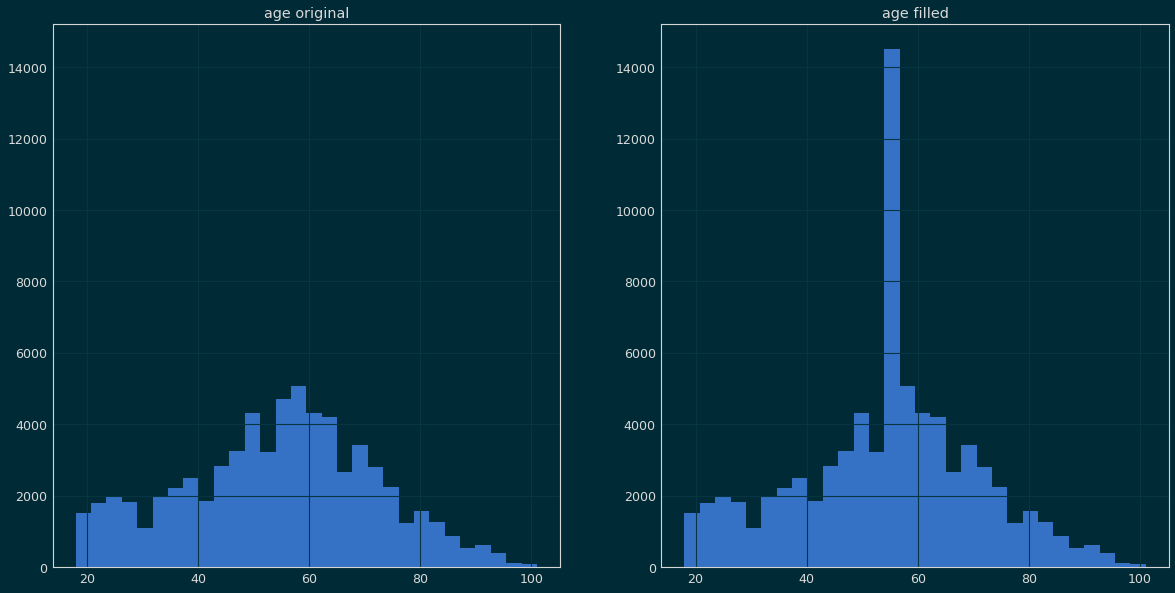

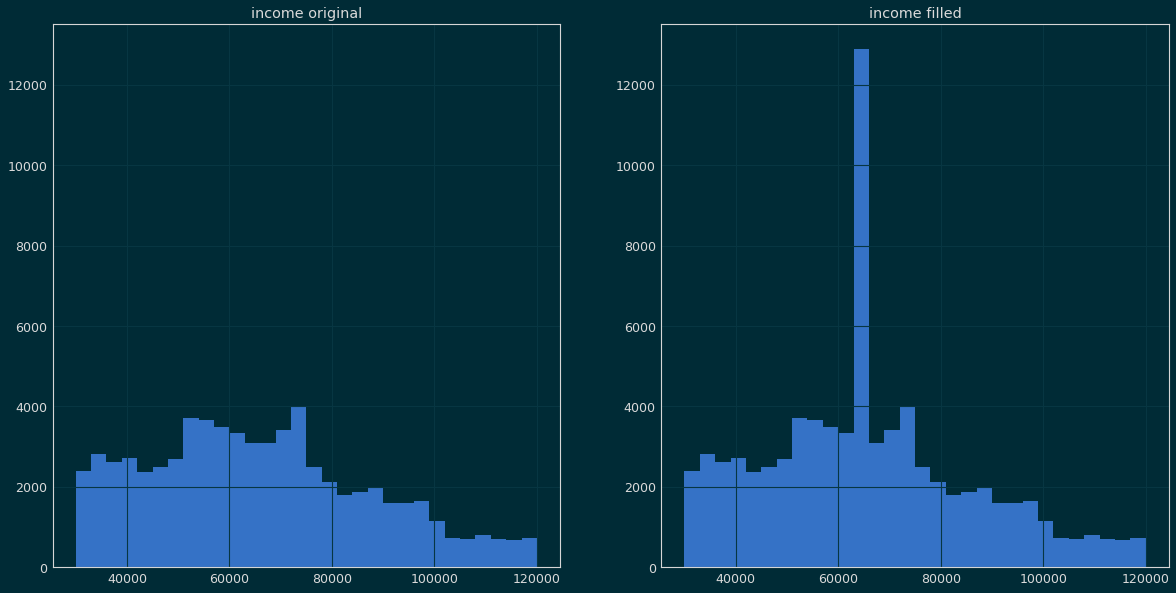

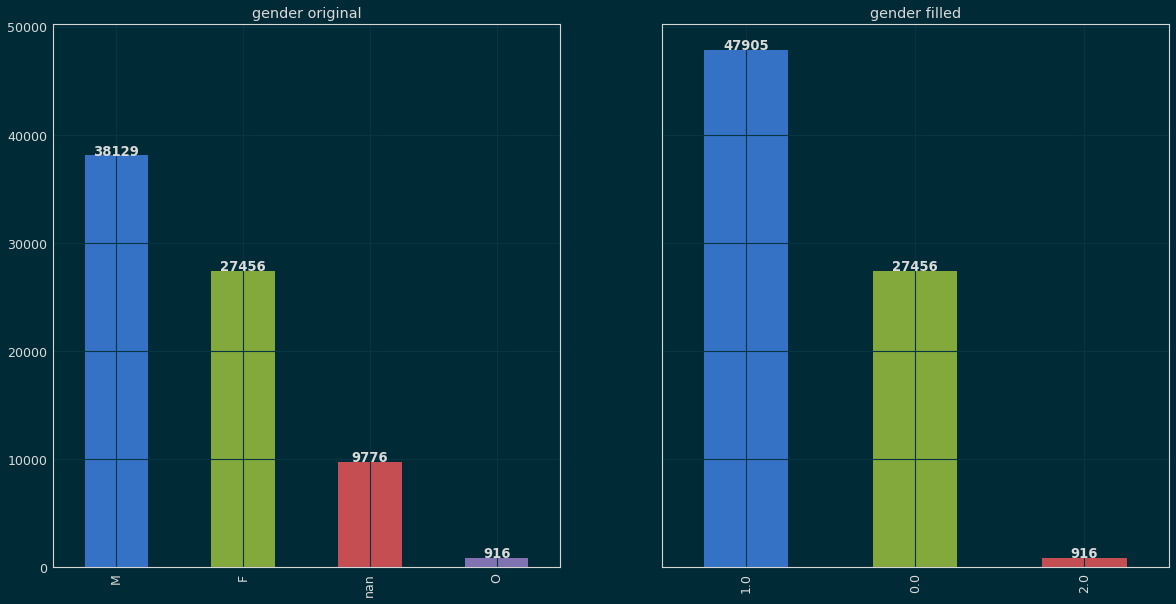

In [173]:
vis.show_imputer_results(data, filled)

It can be seen that filling with medians and most frequent values, clearly modifies the values distribution.

### Filling by fitting an estimator.

All the (relevant) missing data is in the profile dataframe. The problem is that when a customer has one feature missing it has almost all of them missing. That makes it difficult to estimate the missing data but, in the worst case, the imputed missing data will at least follow the distribution of the rest of the data.

In [174]:
print(md.EstimatorImputer.__doc__)


    Fills the demographics missing data with predictions from an estimator.
    


In [175]:
# Show the initial status
data = pd.read_pickle(os.path.join(DATA_INTERIM, 'static_data.pkl'))
data.isnull().mean().sort_values(ascending=False)

view_time                0.249748
age                      0.128164
gender                   0.128164
income                   0.128164
spent_until_complete     0.000000
reward_t                 0.000000
time                     0.000000
offer_id                 0.000000
became_member_on         0.000000
missing_demographics     0.000000
member_epoch_days        0.000000
difficulty               0.000000
duration                 0.000000
offer_type               0.000000
channel_web              0.000000
spent_in_duration        0.000000
channel_mobile           0.000000
channel_email            0.000000
channel_social           0.000000
completed                0.000000
expected_finish          0.000000
finish                   0.000000
success                  0.000000
viewed                   0.000000
actual_reward            0.000000
profit_in_duration       0.000000
profit_until_complete    0.000000
person                   0.000000
dtype: float64

In [176]:
# Create a pipeline (it is necessary to encode before filling the missing data)
encoder_imputer = Pipeline([
    ('encoder', pp.BasicEncoder()),
    ('imputer', md.EstimatorImputer())
])

# Encode and fill with medians and most frequent values.
%time filled = encoder_imputer.fit_transform(data)

print(filled.isnull().mean().sort_values(ascending=False))
filled.head()

CPU times: user 41.1 s, sys: 24.2 ms, total: 41.1 s
Wall time: 41.2 s
view_time                0.249748
member_month             0.000000
channel_mobile           0.000000
time                     0.000000
offer_id                 0.000000
age                      0.000000
became_member_on         0.000000
gender                   0.000000
income                   0.000000
missing_demographics     0.000000
member_epoch_days        0.000000
difficulty               0.000000
duration                 0.000000
offer_type               0.000000
reward_t                 0.000000
channel_web              0.000000
channel_email            0.000000
member_year              0.000000
channel_social           0.000000
completed                0.000000
expected_finish          0.000000
finish                   0.000000
success                  0.000000
viewed                   0.000000
actual_reward            0.000000
profit_in_duration       0.000000
profit_until_complete    0.000000
spent_in_dur

,person,time,offer_id,age,became_member_on,gender,income,missing_demographics,member_epoch_days,difficulty,...,viewed,actual_reward,profit_in_duration,profit_until_complete,spent_in_duration,spent_until_complete,member_day,member_weekday,member_year,member_month
0,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,33.0,2017-04-21,1.0,72000.0,0,17277,0.0,...,1,0.0,22.16,22.16,22.16,22.16,21,4,2017,4
1,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,33.0,2017-04-21,1.0,72000.0,0,17277,0.0,...,1,0.0,8.57,8.57,8.57,8.57,21,4,2017,4
2,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,33.0,2017-04-21,1.0,72000.0,0,17277,5.0,...,0,5.0,17.68,3.57,22.68,8.57,21,4,2017,4
3,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,33.0,2017-04-21,1.0,72000.0,0,17277,10.0,...,0,2.0,94.87,12.11,96.87,14.11,21,4,2017,4
4,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,33.0,2017-04-21,1.0,72000.0,0,17277,10.0,...,0,2.0,67.20,8.27,69.20,10.27,21,4,2017,4


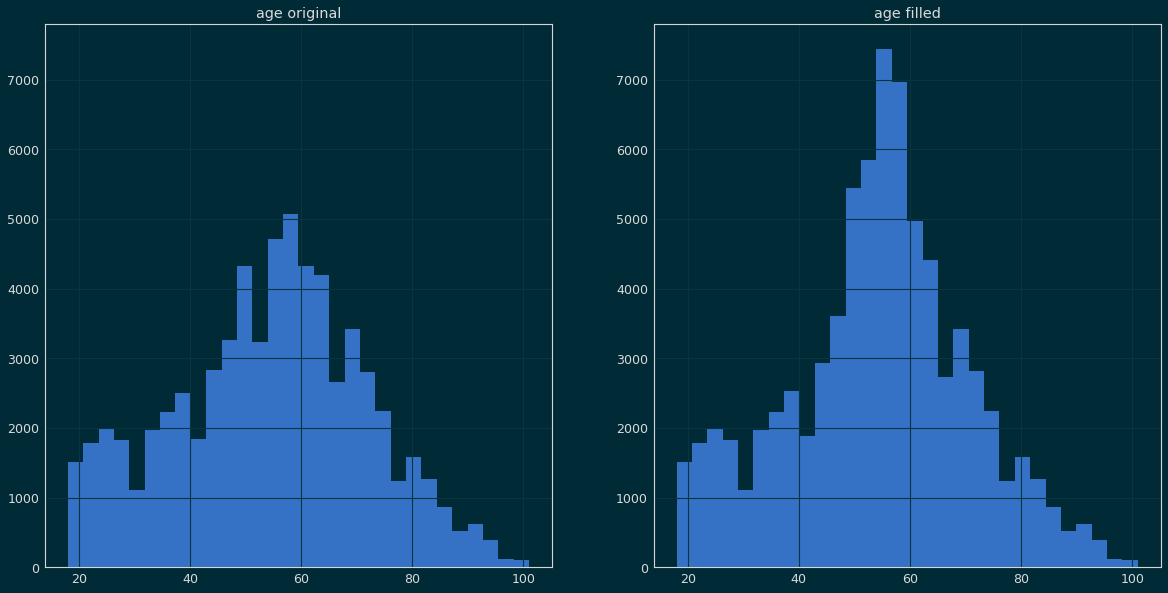

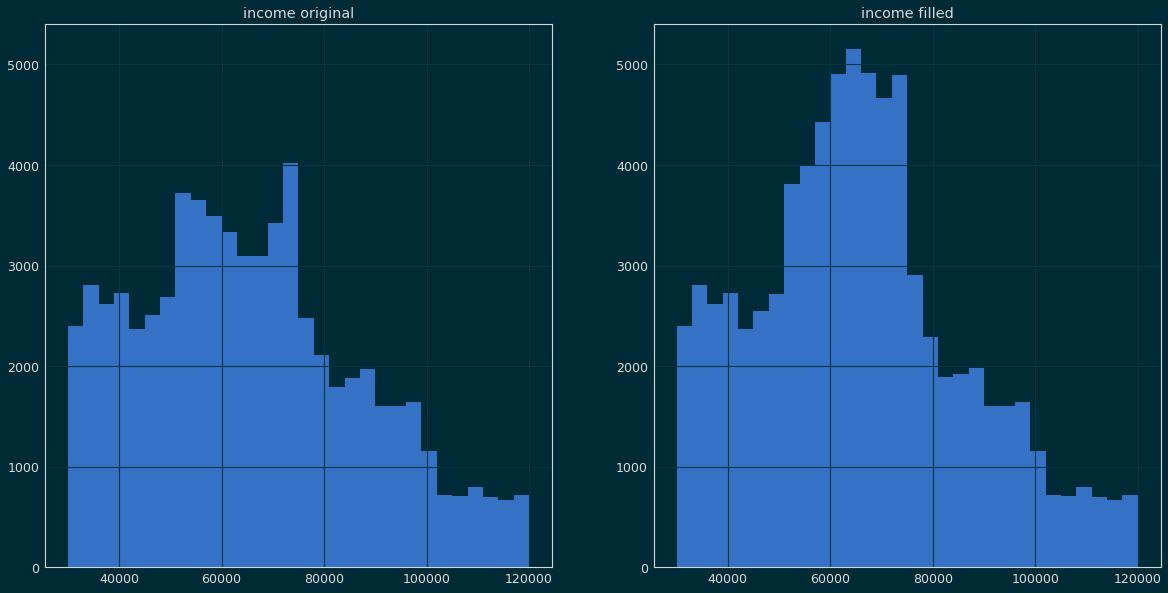

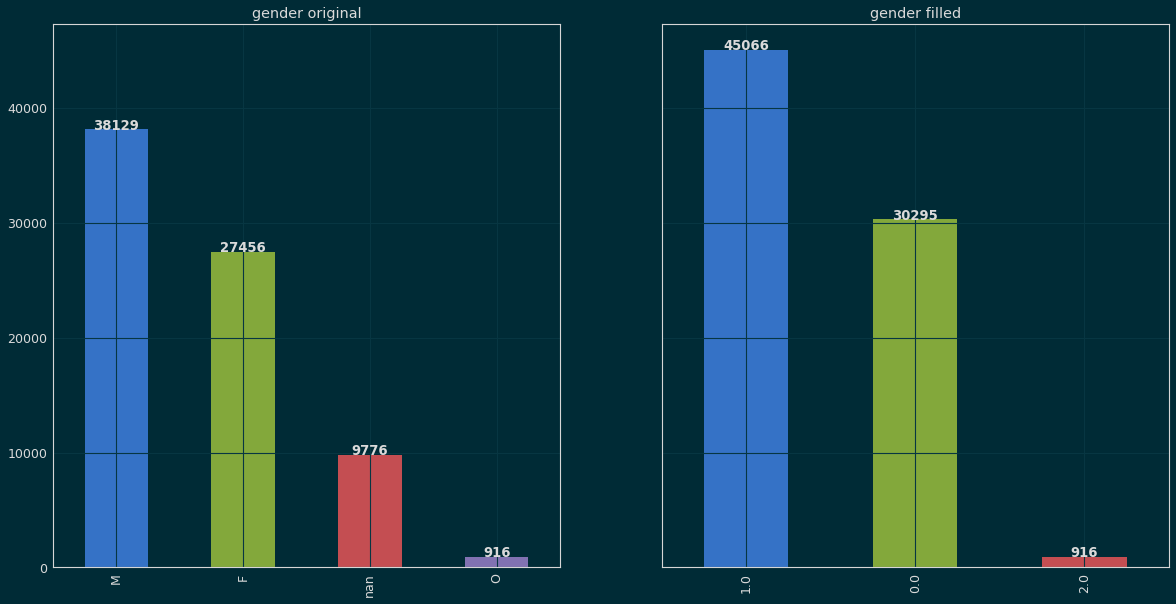

In [177]:
vis.show_imputer_results(data, filled)

That looks better than the BasicImputer, although it takes longer than it. I could use a metric like RMSE or accuracy to see if there is an improvement.

### Missing data imputers evaluation

In [178]:
estimator_imputer = Pipeline([
    ('encoder', pp.BasicEncoder()),
    ('imputer', md.EstimatorImputer())
])

basic_imputer = Pipeline([
    ('encoder', pp.BasicEncoder()),
    ('imputer', md.BasicImputer())
])

#### Let's generate a clean dataset and some fake missing ages, incomes, and genders.

In [183]:
# Get a dataset without missing demographics
clean_data = data[data.missing_demographics == 0]

# Separate targets
target_feats = ['age', 'income', 'gender']
X = clean_data.drop(target_feats, axis=1)
y = clean_data[target_feats]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=2018)

# Join again, but only the training set. The test set will contain NaNs in the targets
data_train = X_train.join(y_train)
X_input = data_train.append(X_test, sort=False).sort_values(by='time')

# Show the results
print(X_input.isnull().mean().sort_values(ascending=False))
X_input.head()

gender                   0.300011
age                      0.300011
income                   0.300011
view_time                0.264763
channel_mobile           0.000000
time                     0.000000
offer_id                 0.000000
became_member_on         0.000000
missing_demographics     0.000000
member_epoch_days        0.000000
difficulty               0.000000
duration                 0.000000
offer_type               0.000000
reward_t                 0.000000
channel_web              0.000000
channel_social           0.000000
channel_email            0.000000
completed                0.000000
expected_finish          0.000000
finish                   0.000000
success                  0.000000
viewed                   0.000000
actual_reward            0.000000
profit_in_duration       0.000000
profit_until_complete    0.000000
spent_in_duration        0.000000
spent_until_complete     0.000000
person                   0.000000
dtype: float64


,person,time,offer_id,became_member_on,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,...,view_time,viewed,actual_reward,profit_in_duration,profit_until_complete,spent_in_duration,spent_until_complete,age,income,gender
48822,a2506fdc02c544a98f491ac97fa62f88,0,fafdcd668e3743c1bb461111dcafc2a4,2018-05-10,0,17661,10.0,10.0,discount,2.0,...,0.0,1,2.0,18.58,12.83,20.58,14.83,64.0,42000.0,M
18018,3cabd0099961416b9810043e7eb0f743,0,ae264e3637204a6fb9bb56bc8210ddfd,2015-12-18,0,16787,10.0,7.0,bogo,10.0,...,42.0,1,10.0,75.03,21.11,85.03,31.11,43.0,52000.0,M
578,020d72e77c704c42bb0a858c1aaa3bcd,0,3f207df678b143eea3cee63160fa8bed,2017-06-26,0,17343,0.0,4.0,informational,0.0,...,36.0,1,0.0,40.87,40.87,40.87,40.87,68.0,57000.0,F
65149,da5b9a0ab0424d51a502f9423dc75c81,0,2906b810c7d4411798c6938adc9daaa5,2018-07-22,0,17734,10.0,7.0,discount,2.0,...,84.0,1,0.0,5.15,5.15,5.15,5.15,23.0,32000.0,M
66253,ddd92ad1b92f4a79be14e1067731a87d,0,3f207df678b143eea3cee63160fa8bed,2017-10-08,0,17447,0.0,4.0,informational,0.0,...,96.0,1,0.0,0.00,0.00,0.00,0.00,31.0,56000.0,M


#### Let's test both imputers now

In [184]:
%time X_out_basic = basic_imputer.fit_transform(X_input)

CPU times: user 415 ms, sys: 13 µs, total: 415 ms
Wall time: 413 ms


In [185]:
%time X_out_estimator = estimator_imputer.fit_transform(X_input)

CPU times: user 29.7 s, sys: 4.19 ms, total: 29.7 s
Wall time: 29.7 s


#### Evaluation

In [187]:
# Name the true values of the missing data
age_true = y_test.age
income_true = y_test.income
gender_true = pp.gender_encode(y_test.loc[:, ['gender']])

# Evaluate the Basic Imputer
print('Basic Imputer\n')

age_basic_pred = X_out_basic.loc[y_test.index, :].age
income_basic_pred = X_out_basic.loc[y_test.index, :].income
gender_basic_pred = X_out_basic.loc[y_test.index, :].gender

print('Age RMSE: {}'.format(np.sqrt(mse(age_true, age_basic_pred))))
print('Income RMSE: {}'.format(np.sqrt(mse(income_true, income_basic_pred))))
print('Gender Accuracy: {}'.format(np.sqrt(accuracy_score(gender_true, 
                                                          gender_basic_pred))))
print('-'*100)

# Evaluate the Estimator Imputer
print('Estimator Imputer\n')

age_est_pred = X_out_estimator.loc[y_test.index, :].age
income_est_pred = X_out_estimator.loc[y_test.index, :].income
gender_est_pred = X_out_estimator.loc[y_test.index, :].gender

print('Age RMSE: {}'.format(np.sqrt(mse(age_true, age_est_pred))))
print('Income RMSE: {}'.format(np.sqrt(mse(income_true, income_est_pred))))
print('Gender Accuracy: {}'.format(np.sqrt(accuracy_score(gender_true, 
                                                          gender_est_pred))))
print('-'*100)

Basic Imputer

Age RMSE: 17.358943390751815
Income RMSE: 21749.830690857074
Gender Accuracy: 0.7546823081245384
----------------------------------------------------------------------------------------------------
Estimator Imputer

Age RMSE: 16.64788070800291
Income RMSE: 20668.84273603623
Gender Accuracy: 0.7843514886717338
----------------------------------------------------------------------------------------------------


#### As expected, the Estimator Imputer gives better results in all the features, but it takes much longer to process the data.

# 5 Clustering <a id='clustering'></a>
[Top](#top)